# With metadata to better data! (Meta)Data transfer from and to Coscine

The [Coscine research data platform](https://www.coscine.de) provides an API interface to transfer metadata annotated data to Coscine in automated processes. In the workshop, we will show in small-scale steps how to move data to Coscine using a JupyterNotebook (Python) and Coscine's personal authentication token, and how to specify the metadata using the application profile provided by the application. Prior knowledge of Python is desirable.

First things first, you need a Coscine project. You should have received an invite to the Coscine Project: Automating (Meta)Data.


Create a configuration file:

`config.json`

Copy and paste your token 

```JSON
{
    "RESOURCE": "Test",
    "PROJECT": "Automating (Meta)Data", 
    "TOKEN": ""
}
```

Next, head to your [user profile](https://coscine.rwth-aachen.de/user/) and get your Access Token. 

We'll copy and paste this into your config file next to: `TOKEN`.

Install Python and Jupyter in the extensions tab. This may make it easier to code along with me.

Now let's load all dependencies and configurations into our jupyter notebook.

In [3]:
import coscine
import json
from datetime import datetime
from pathlib import Path

If you have any errors loading the packages, run the code below with the associated package name:

In [ ]:
pip install PACKAGE_NAME

In [2]:
! pip install coscine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 888.1 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 11.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.7 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 44.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

Load the configuration:

In [4]:
with open ("config.json") as f:
    cfg = json.load(f)

RESOURCE: str = cfg["RESOURCE"]
PROJECT: str = cfg["PROJECT"]
TOKEN: str = cfg["TOKEN"]


FileNotFoundError: [Errno 2] No such file or directory: 'config.json'

We use the Coscine package to connect with Coscine REST API, which enables us to interact with our project and resource. 

For more information and other examples: [Coscine Python SDK](https://git.rwth-aachen.de/coscine/community-features/coscine-python-sdk)

In [4]:
client = coscine.ApiClient(TOKEN)
project = client.project(PROJECT)
resource = project.resource(RESOURCE)

                      _              
                     (_)             
    ___ ___  ___  ___ _ _ __   ___   
   / __/ _ \/ __|/ __| | '_ \ / _ \  
  | (_| (_) \__ \ (__| | | | |  __/  
   \___\___/|___/\___|_|_| |_|\___|  
 ___________________________________ 
  Coscine Python SDK 0.10.2   
  https://coscine.de/                



In [5]:
print(project)

-----------------------  ----------------------------------------------------------
ID                       41ea010a-92e2-4caf-8c28-bde8c96ff226
Name                     Automating (Meta)Data Transfer to Coscine (RDM II-modular)
Display Name             Automating (Meta)Data
Description              Automating metadata transfer to Coscine Workshop
Principal Investigators  Catherine Gonzalez
Disciplines              Computer Science 409
Organizations            RWTH Aachen University
Start Date               2023-11-29
End Date                 2028-11-30
Date created             2023-11-29
Creator
Grant ID
PID                      21.11102/41ea010a-92e2-4caf-8c28-bde8c96ff226
Slug                     automating-metadata-05605743
Keywords
Visibility               Project Members
-----------------------  ----------------------------------------------------------


In [6]:
print(resource)

-------------------  ---------------------------------------------
ID                   67de7c6d-fdac-4ba9-91be-be4fc3c3f6b7
Name                 Test
Display Name         Test
Description          Automating metadata workshop
Disciplines          Computer Science 409
Date created         2023-12-04
Creator              7c034178-8c50-44c2-b90e-a1ea72954d0c
PID                  21.11102/67de7c6d-fdac-4ba9-91be-be4fc3c3f6b7
Keywords             []
Visibility           Project Members
Application Profile  Basisprofil
Usage rights
License
Archived             False
-------------------  ---------------------------------------------


Get the metadata form and take a look at it:

In [7]:
metadata = resource.metadata_form()
print(metadata)

Required    Controlled    Type    Range    Field          Value
----------  ------------  ------  -------  -------------  ----------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator        {ME}
True        False         date    1 - 1    Creation Date  2023-12-04
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type


This form is a dictionary-like data structure, so you can interact with it like a python dictionary:

Now will interact with the metadata form and supply metadata and upload a file with that metadata to Coscine.

In [7]:
metadata["Title"] = "My cool Metadata"

In [10]:
metadata["Type"] = "Integer"

ValueError: The field 'Type' is controlled by a vocabulary. The value 'Integer' that you have provided did not match any of the entries in the vocabulary!

The error is because the field is a controlled vocabulary. Let's see what is allowed:

In [11]:
print(metadata.field("Type").vocabulary)

Collection
Dataset
Event
Image
Interactive Resource
Moving Image
Physical Object
Service
Software
Sound
Still Image
Text


In [8]:
metadata["Type"] = "Image"

In [13]:
print(metadata)

Required    Controlled    Type    Range    Field          Value
----------  ------------  ------  -------  -------------  ----------------
True        False         str     1 - 128  Title          My cool Metadata
True        False         str     1 - 128  Creator        {ME}
True        False         date    1 - 1    Creation Date  2023-12-04
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type           Image


Now we will look at an example where we get input from a user regarding which value that we want.

In [43]:
print(metadata.field("Subject Area").vocabulary)

Acoustics
African, American and Oceania Studies 
Agricultural Economics and Sociology
Agriculture, Forestry and Veterinary Medicine
Anaesthesiology
Analytical Chemistry, Method Development (Chemistry)
Analytical Chemistry, Method Development (Chemistry)
Anatomy
Ancient Cultures
Ancient History
Animal Ecology, Biodiversity and Ecosystem Research
Animal Husbandry, Breeding and Hygiene
Animal Nutrition and Nutrition Physiology
Applied Linguistics, Experimental Linguistics, Computational Linguistics
Applied Mechanics, Statics and Dynamics
Architecture, Building and Construction History, Construction Research, Sustainable Building Technology
Art History
Asian Studies
Astrophysics and Astronomy
Astrophysics and Astronomy
Atmospheric Science
Atmospheric Science, Oceanography and Climate Research
Automation, Control Systems, Robotics, Mechatronics, Cyber Physical Systems
Basic Research in Biology and Medicine
Basic Research on Pathogenesis, Diagnostics and Therapy and Clinical Veterinary Medic

Enumerate Allows to index into the list. Returns a tuple so each item in the list is paired with its index.

Removes need to manually count items in the list

In [44]:
allowed_value_subject = list(metadata.field("Subject Area").vocabulary)

In [45]:
allowed_value_subject

['Acoustics',
 'African, American and Oceania Studies\xa0',
 'Agricultural Economics and Sociology',
 'Agriculture, Forestry and Veterinary Medicine',
 'Anaesthesiology',
 'Analytical Chemistry, Method Development (Chemistry)',
 'Analytical Chemistry, Method Development (Chemistry)',
 'Anatomy',
 'Ancient Cultures',
 'Ancient History',
 'Animal Ecology, Biodiversity and Ecosystem Research',
 'Animal Husbandry, Breeding and Hygiene',
 'Animal Nutrition and Nutrition Physiology',
 'Applied Linguistics, Experimental Linguistics, Computational Linguistics',
 'Applied Mechanics, Statics and Dynamics',
 'Architecture, Building and Construction History, Construction Research, Sustainable Building Technology',
 'Art History',
 'Asian Studies',
 'Astrophysics and Astronomy',
 'Astrophysics and Astronomy',
 'Atmospheric Science',
 'Atmospheric Science, Oceanography and Climate Research',
 'Automation, Control Systems, Robotics, Mechatronics, Cyber Physical Systems',
 'Basic Research in Biology a

In [46]:
subject_vocabulary = {}
for item, value in enumerate(allowed_value_subject):
    subject_vocabulary[item] = value

In [47]:
subject_vocabulary

{0: 'Acoustics',
 1: 'African, American and Oceania Studies\xa0',
 2: 'Agricultural Economics and Sociology',
 3: 'Agriculture, Forestry and Veterinary Medicine',
 4: 'Anaesthesiology',
 5: 'Analytical Chemistry, Method Development (Chemistry)',
 6: 'Analytical Chemistry, Method Development (Chemistry)',
 7: 'Anatomy',
 8: 'Ancient Cultures',
 9: 'Ancient History',
 10: 'Animal Ecology, Biodiversity and Ecosystem Research',
 11: 'Animal Husbandry, Breeding and Hygiene',
 12: 'Animal Nutrition and Nutrition Physiology',
 13: 'Applied Linguistics, Experimental Linguistics, Computational Linguistics',
 14: 'Applied Mechanics, Statics and Dynamics',
 15: 'Architecture, Building and Construction History, Construction Research, Sustainable Building Technology',
 16: 'Art History',
 17: 'Asian Studies',
 18: 'Astrophysics and Astronomy',
 19: 'Astrophysics and Astronomy',
 20: 'Atmospheric Science',
 21: 'Atmospheric Science, Oceanography and Climate Research',
 22: 'Automation, Control Syste

In [48]:
subject_selection = input(f"Enter value by selecting the respective number {subject_vocabulary}")
metadata["Subject Area"] = subject_vocabulary[int(subject_selection)]

In [15]:
print(metadata)

Required    Controlled    Type    Range    Field          Value
----------  ------------  ------  -------  -------------  ----------------------------------------------------
True        False         str     1 - 128  Title          My cool Metadata
True        False         str     1 - 128  Creator        {ME}
True        False         date    1 - 1    Creation Date  2023-12-04
False       True          str     0 - 128  Subject Area   Analytical Chemistry, Method Development (Chemistry)
False       True          str     0 - 128  Type           Image


Let's deal with the date. It needs to be formatted as a datetime object:

In [16]:
date = "2023-12-06"
type(date)

str

In [17]:
metadata["Creation Date"] = date

TypeError: While setting value for field Creation Date: Expected type <class 'datetime.date'> but got <class 'str'>!

In [18]:
metadata["Creation Date"] = datetime.strptime(date, "%Y-%m-%d").date()

In [19]:
print(metadata)

Required    Controlled    Type    Range    Field          Value
----------  ------------  ------  -------  -------------  ----------------------------------------------------
True        False         str     1 - 128  Title          My cool Metadata
True        False         str     1 - 128  Creator        {ME}
True        False         date    1 - 1    Creation Date  2023-12-06
False       True          str     0 - 128  Subject Area   Analytical Chemistry, Method Development (Chemistry)
False       True          str     0 - 128  Type           Image


Add whatever else is missing:

In [20]:
metadata["Creator"] = "Cat"

In [26]:
print(metadata)

Required    Controlled    Type    Range    Field          Value
----------  ------------  ------  -------  -------------  ----------------------------------------------------
True        False         str     1 - 128  Title          My cool Metadata
True        False         str     1 - 128  Creator        Cat
True        False         date    1 - 1    Creation Date  2023-12-06
False       True          str     0 - 128  Subject Area   Analytical Chemistry, Method Development (Chemistry)
False       True          str     0 - 128  Type           Image


In [21]:
metadata["Creator"] = ["Cat", "Nikki", "Kseniia"]

In [22]:
print(metadata)

Required    Controlled    Type    Range    Field          Value
----------  ------------  ------  -------  -------------  ----------------------------------------------------
True        False         str     1 - 128  Title          My cool Metadata
True        False         str     1 - 128  Creator        Cat
                                                          Nikki
                                                          Kseniia
True        False         date    1 - 1    Creation Date  2023-12-06
False       True          str     0 - 128  Subject Area   Analytical Chemistry, Method Development (Chemistry)
False       True          str     0 - 128  Type           Image


Now we upload the metadata and the data. We supplied a dummy text file here called `myData.txt` that you should rename to your file to your_name_test.

If you know someone has a same name then try to just make your file unique.

Key is to not get an error indicating a file is going to be uploaded that has already been uploaded with that same name.

In [ ]:
local_file_name = "cat_test_file.txt"
coscine_file_name = "here_is_a_different_name.txt"

with open(local_file_name, 'rb') as f:
    resource.upload(coscine_file_name, f, metadata)

# note: overwriting files will only work with Coscine Python SDK version 0.10.3 

<!-- If you were working with a nested directory structure or larger data, you'd want to use the S3 credentials to interact with the resource via s3 protocol. 

We can get these using the API: -->

Both web resources and S3 resources allow you to create directories.

S3 is more stable to use if you have large files or a lot of files.  For our workshop we will use a web resource

Due to the storage infrastructure, directories many times the first file in the folder will have the same metadata as the folder.

This let's us make directories:

In [26]:
# we can supply a path to our coscine_file_name and it will create a folder
coscine_file_name = "my_cool_directory/Cat_Test_file.txt"
local_file_name = "my_second_file.txt"

And upload files to a directory:

In [27]:
with open(local_file_name, 'rb') as file_path:
    resource.upload(coscine_file_name, file_path, metadata)


my_cool_directory/Cat_Test_file.txt: 100%|##########| 230/230 [00:00<00:00, 453B/s]


Let's add metadata to the folder as well:

In [32]:
folder = resource.file("my_cool_directory")

In [33]:
folder.update_metadata(metadata)

## Let's get fancier and extract metadata from a file

Let's try getting some metadata out of an image file. For this we use the pillow (PIL) module.

The data folder includes a dataset titled 3dsem which includes some JPEG and TIFF images

data source
Authors: Tafti, Ahmad P and Kirkpatrick, Andrew B and Holz, Jessica D and Owen, Heather A and Yu, Zeyun

DOI: 10.7910/DVN/HVBW0Q

License: CC-0

We can extend the base profile in Coscine to fit some of this metadata. Which we've already done! Yay!

Let's create a new resource within out project. We can do this via Coscine web interface.

In [8]:
from PIL import Image, ExifTags

In [9]:
image = Image.open("data/Pollen1001.jpg")

In [10]:
image.size

(854, 640)

In [11]:
print(image.format, image.size, image.mode)

JPEG (854, 640) RGB


In [12]:
getattr(image, "n_frames", 1)

1

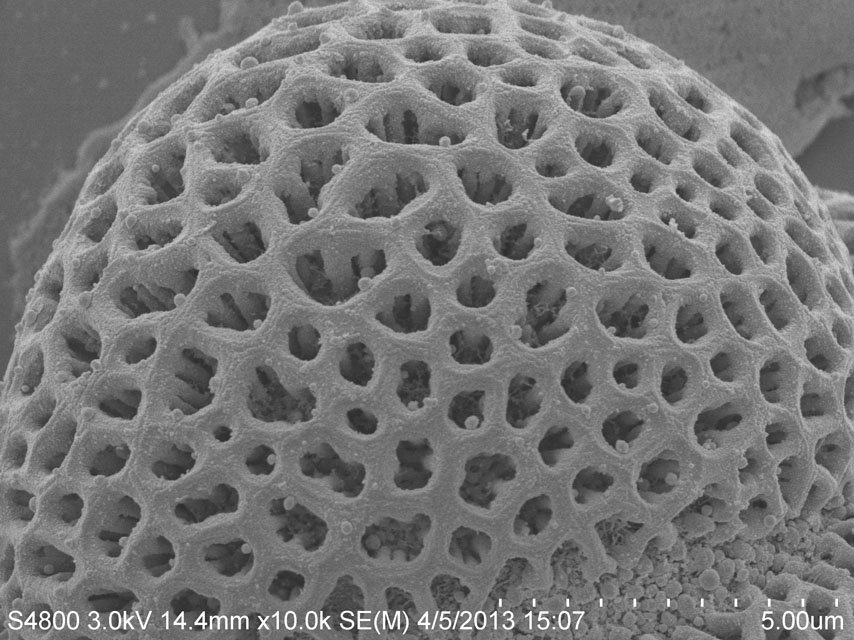

In [13]:
image.show()

In [14]:
image_exif = image._getexif()
exif =  { ExifTags.TAGS[k]: v for k, v in image_exif.items() if k in ExifTags.TAGS and type(v) is not bytes }

In [15]:
exif

{'ImageWidth': 2560,
 'ImageLength': 1920,
 'BitsPerSample': 8,
 'Compression': 1,
 'PhotometricInterpretation': 3,
 'StripOffsets': (8,
  10248,
  20488,
  30728,
  40968,
  51208,
  61448,
  71688,
  81928,
  92168,
  102408,
  112648,
  122888,
  133128,
  143368,
  153608,
  163848,
  174088,
  184328,
  194568,
  204808,
  215048,
  225288,
  235528,
  245768,
  256008,
  266248,
  276488,
  286728,
  296968,
  307208,
  317448,
  327688,
  337928,
  348168,
  358408,
  368648,
  378888,
  389128,
  399368,
  409608,
  419848,
  430088,
  440328,
  450568,
  460808,
  471048,
  481288,
  491528,
  501768,
  512008,
  522248,
  532488,
  542728,
  552968,
  563208,
  573448,
  583688,
  593928,
  604168,
  614408,
  624648,
  634888,
  645128,
  655368,
  665608,
  675848,
  686088,
  696328,
  706568,
  716808,
  727048,
  737288,
  747528,
  757768,
  768008,
  778248,
  788488,
  798728,
  808968,
  819208,
  829448,
  839688,
  849928,
  860168,
  870408,
  880648,
  890888,
  

Now here's a challenge. See if you can extract metadata from the file, update the metadata form, and upload the file to Coscine.

- Coscine/Python Script Examples: 
-- https://coscine.pages.rwth-aachen.de/community-features/coscine-technical-adaption/
- Coscine API Documentation: 
-- https://coscine.rwth-aachen.de/coscine/apps/apidocs/#tag/admin
- Python SDK Documentation:
-- https://coscine.pages.rwth-aachen.de/community-features/coscine-python-sdk/index.html


In [23]:
with open ("config.json") as f:
    cfg = json.load(f)

RESOURCE: str = cfg["RESOURCE"]
PROJECT: str = cfg["PROJECT"]
TOKEN: str = cfg["TOKEN"]

In [24]:
client = coscine.ApiClient(TOKEN)
project = client.project(PROJECT)
resource = project.resource(RESOURCE)

                      _              
                     (_)             
    ___ ___  ___  ___ _ _ __   ___   
   / __/ _ \/ __|/ __| | '_ \ / _ \  
  | (_| (_) \__ \ (__| | | | |  __/  
   \___\___/|___/\___|_|_| |_|\___|  
 ___________________________________ 
  Coscine Python SDK 0.10.2   
  https://coscine.de/                



In [25]:
print(resource)

-------------------  ---------------------------------------------
ID                   177e0812-bb83-48f7-9f53-16e2442cdd01
Name                 Test Images
Display Name         Test Images
Description          for the coscine metadata automation workshop
Disciplines          Computer Science 409
Date created         2023-12-01
Creator              7c034178-8c50-44c2-b90e-a1ea72954d0c
PID                  21.11102/177e0812-bb83-48f7-9f53-16e2442cdd01
Keywords             []
Visibility           Project Members
Application Profile  Bild Metadaten
Usage rights
License
Archived             False
-------------------  ---------------------------------------------


In [26]:
metadata = resource.metadata_form()
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ----------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator          {ME}
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type
False       True          str     0 - 128  Compression
False       True          str     0 - 128  Resolution Unit
False       False         float   0 - 128  X Resolution
False       False         float   0 - 128  Y Resolution
False       False         float   0 - 128  Image Width
False       False         float   0 - 128  Image Length


In [27]:
print(metadata.field("Compression").selection)

['Uncompressed', 'PackBits', 'LZW ', 'JPEG', 'Deflate']


In [28]:
compressionMap = {
    1: "Uncompressed",
    6: "JPEG",
    32773: "LZW",
    8: "Deflate"
    }

In [48]:
exif

{'ImageWidth': 2560,
 'ImageLength': 1920,
 'BitsPerSample': 8,
 'Compression': 1,
 'PhotometricInterpretation': 3,
 'StripOffsets': (8,
  10248,
  20488,
  30728,
  40968,
  51208,
  61448,
  71688,
  81928,
  92168,
  102408,
  112648,
  122888,
  133128,
  143368,
  153608,
  163848,
  174088,
  184328,
  194568,
  204808,
  215048,
  225288,
  235528,
  245768,
  256008,
  266248,
  276488,
  286728,
  296968,
  307208,
  317448,
  327688,
  337928,
  348168,
  358408,
  368648,
  378888,
  389128,
  399368,
  409608,
  419848,
  430088,
  440328,
  450568,
  460808,
  471048,
  481288,
  491528,
  501768,
  512008,
  522248,
  532488,
  542728,
  552968,
  563208,
  573448,
  583688,
  593928,
  604168,
  614408,
  624648,
  634888,
  645128,
  655368,
  665608,
  675848,
  686088,
  696328,
  706568,
  716808,
  727048,
  737288,
  747528,
  757768,
  768008,
  778248,
  788488,
  798728,
  808968,
  819208,
  829448,
  839688,
  849928,
  860168,
  870408,
  880648,
  890888,
  

In [29]:
metadata["Compression"] = compressionMap[exif["Compression"]]

In [30]:
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ------------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator          {ME}
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type
False       True          str     0 - 128  Compression      Uncompressed
False       True          str     0 - 128  Resolution Unit
False       False         float   0 - 128  X Resolution
False       False         float   0 - 128  Y Resolution
False       False         float   0 - 128  Image Width
False       False         float   0 - 128  Image Length


In [31]:
metadata.field('Resolution Unit').selection

['No absolute unit of measure',
 'pixels per inch (PPI)',
 'pixels per centimeter (PPCM)']

In [32]:
resolutionMap = {
    1:'No absolute unit of measure',
    2:'pixels per inch (PPI)',
    3:'pixels per centimeter (PPCM)'
}

In [33]:
metadata['Resolution Unit'] = resolutionMap[exif['ResolutionUnit']]
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ---------------------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator          {ME}
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type
False       True          str     0 - 128  Compression      Uncompressed
False       True          str     0 - 128  Resolution Unit  pixels per inch (PPI)
False       False         float   0 - 128  X Resolution
False       False         float   0 - 128  Y Resolution
False       False         float   0 - 128  Image Width
False       False         float   0 - 128  Image Length


In [34]:
metadata["Compression"] =  compressionMap[exif['Compression']]
metadata['Resolution Unit'] = resolutionMap[exif['ResolutionUnit']]

In [35]:
print(exif['XResolution'])
print(type(exif['XResolution']))

512.0
<class 'PIL.TiffImagePlugin.IFDRational'>


In [36]:
metadata['X Resolution'] = float(exif['XResolution'])

In [37]:
metadata['Y Resolution'] =  float(exif['YResolution'])

In [38]:
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ---------------------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator          {ME}
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type
False       True          str     0 - 128  Compression      Uncompressed
False       True          str     0 - 128  Resolution Unit  pixels per inch (PPI)
False       False         float   0 - 128  X Resolution     512.0
False       False         float   0 - 128  Y Resolution     512.0
False       False         float   0 - 128  Image Width
False       False         float   0 - 128  Image Length


In [39]:
metadata["Image Width"] =  float(exif["ImageWidth"])
metadata["Image Length"] = float(exif['ImageLength'])

In [40]:
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ---------------------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator          {ME}
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area
False       True          str     0 - 128  Type
False       True          str     0 - 128  Compression      Uncompressed
False       True          str     0 - 128  Resolution Unit  pixels per inch (PPI)
False       False         float   0 - 128  X Resolution     512.0
False       False         float   0 - 128  Y Resolution     512.0
False       False         float   0 - 128  Image Width      2560.0
False       False         float   0 - 128  Image Length     1920.0


In [49]:
subject_selection = input(f"Enter value by selecting the respective number {subject_vocabulary}")
metadata["Subject Area"] = subject_vocabulary[int(subject_selection)]

In [50]:
print(metadata.field("Type").vocabulary)

Collection
Dataset
Event
Image
Interactive Resource
Moving Image
Physical Object
Service
Software
Sound
Still Image
Text


In [51]:
metadata["Type"] = "Image"

In [52]:
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ----------------------------------------------------
True        False         str     1 - 128  Title
True        False         str     1 - 128  Creator          {ME}
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area     Analytical Chemistry, Method Development (Chemistry)
False       True          str     0 - 128  Type             Image
False       True          str     0 - 128  Compression      Uncompressed
False       True          str     0 - 128  Resolution Unit  pixels per inch (PPI)
False       False         float   0 - 128  X Resolution     512.0
False       False         float   0 - 128  Y Resolution     512.0
False       False         float   0 - 128  Image Width      2560.0
False       False         float   0 - 128  Image Length     1920.0


In [53]:
metadata["Creator"] = ["Cat"]
metadata["Title"] = ["Pollen"]

In [54]:
print(metadata)

Required    Controlled    Type    Range    Field            Value
----------  ------------  ------  -------  ---------------  ----------------------------------------------------
True        False         str     1 - 128  Title            Pollen
True        False         str     1 - 128  Creator          Cat
True        False         date    1 - 1    Creation Date    2023-12-01
False       True          str     0 - 128  Subject Area     Analytical Chemistry, Method Development (Chemistry)
False       True          str     0 - 128  Type             Image
False       True          str     0 - 128  Compression      Uncompressed
False       True          str     0 - 128  Resolution Unit  pixels per inch (PPI)
False       False         float   0 - 128  X Resolution     512.0
False       False         float   0 - 128  Y Resolution     512.0
False       False         float   0 - 128  Image Width      2560.0
False       False         float   0 - 128  Image Length     1920.0


In [59]:
coscine_file_name = 'Pollen1003.jpg'

with open('data/Pollen1003.jpg', "rb") as file_path:
    resource.upload(coscine_file_name, file_path, metadata)

# note: overwriting files will only work with Coscine Python SDK version 0.10.3 

Pollen1003.jpg: 100%|##########| 155k/155k [00:00<00:00, 339kB/s]
